# Problem Statement

You are working for a (fictitious) eCommerce company who has been able to collect information on the income of a small group of their customers using a survey. However, they have been able to collect much more customer data through their website and are hoping that they can use this to predict the incomes of the rest of their customers to help them make business decisions such as how best to price their products and target their advertising.
You have been provided with a small sample of the complete data (note: this data has already been cleaned, so there is no need to check for incorrect, duplicate, or missing data). This contains information such as a customer’s salary, their activity on the website and various demographic attributes.

### Import the required python libraries

In [1]:
# @title
import requests
import io
import scipy
import statsmodels.api as sm
from sklearn.feature_selection import f_regression
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import time # We will be using this to time the efficiency of vectorisation
import sklearn.linear_model # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn import kernel_ridge
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We will be using the imbuilt sclaing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
import seaborn as sns
from mpl_toolkits import mplot3d # Used to make a 3D plot used to demonstrate multidimensional relationships.
from sklearn.preprocessing import PolynomialFeatures # A preprocessing function allowing us to include polynomial features into our model
from google.colab import files # We will be importing a csv file I have provided for one section.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # We will be using these to encode categorical features
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split # We will be using this to split our datasets into training and testing sets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful
import seaborn as sns; sns.set()
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
from tensorflow.keras.activations import sigmoid, linear, relu # Activation functions we will use
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.optimizers import SGD # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.
from tensorflow.keras.layers import Input, Dense, Dropout # The layers we will be using to construct our network.
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.metrics import BinaryAccuracy # Accuracy Metric for classification
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.

In [2]:
# @title
from IPython.display import HTML
def pretty_print_df(value_counts_):
  "Quick function to display value counts more nicely"
  display(HTML(pd.DataFrame(value_counts_).to_html()))

### **Load the Dataset**


The data was downloaded from moodle and uploaded to my github for ease.


In [3]:
# @title
url = "https://raw.githubusercontent.com/0xsas/courseworkDatasets/main/datasets/courseworkData.csv" # url to the dataset
download = requests.get(url).content # save the raw dataset to the variable download
df = pd.read_csv(io.StringIO(download.decode('utf-8'))) # use the ioString library to decode your data and pass it as a pandas dataframe.
df.head()

,Age,SiteSpending,SiteTime,RecommendImpression,Education,WorkType,Sex,Region,Salary
0,32,314.06,30.14,0,Degree,Private sector,Male,London,60173.49
1,20,3758.36,149.36,4,GCSE,Private sector,Female,South East,42965.45
2,36,601.72,21.87,0,Masters,Private sector,Male,East of England,54924.41
3,21,44.89,182.80,9,Masters,Private sector,Female,Northern Ireland,26734.99
4,24,614.80,194.34,0,GCSE,Private sector,Male,Scotland,15325.23


### Exploratory Data Analysis

1. Age: numerical value showing the ages of the site users.
2. SiteSpending: Total amount a user spends on our website.
3. SiteTime: Total amount of time spent on our website.
4. RecommendImpression: number of interactions on our site.
5. Education: highest level of completed eductaion of the users.
6. WorkType: what job sector they work in.
7. Sex: Users gender
8. Region: what location in the country the user is in.
9. Salary: how much money the user makes.

In [4]:
df.dtypes

Age                      int64
SiteSpending           float64
SiteTime               float64
RecommendImpression      int64
Education               object
WorkType                object
Sex                     object
Region                  object
Salary                 float64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.57700,13.147507,19.00,29.0000,39.000,49.0000,82.00
SiteSpending,1000.0,930.07920,1016.477186,40.43,219.9125,440.490,1246.6950,4392.22
SiteTime,1000.0,151.08232,85.842607,5.11,79.3375,153.525,219.6450,300.88
RecommendImpression,1000.0,4.77900,3.671190,0.00,2.0000,4.000,7.0000,17.00
Salary,1000.0,46823.85886,22595.237921,12441.66,27678.3800,46004.480,60967.4325,145225.72


In [6]:
# @title
categorical_columns= ['Education', 'WorkType', 'WorkType', 'Sex', 'Region']
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(df[col].value_counts())
  print()


Categories and number of occurrences for 'Education'


,Education
Degree,282
PhD,158
Other,141
A Level,136
Masters,119
GCSE,103
None,61



Categories and number of occurrences for 'WorkType'


,WorkType
Private sector,612
Unemployed,249
Public Sector,124
Self Employed,15



Categories and number of occurrences for 'WorkType'


,WorkType
Private sector,612
Unemployed,249
Public Sector,124
Self Employed,15



Categories and number of occurrences for 'Sex'


,Sex
Female,544
Male,456



Categories and number of occurrences for 'Region'


,Region
Scotland,158
South East,138
London,110
North West,91
Yorkshire and The Humber,81
East of England,79
West Midlands,78
South West,71
Northern Ireland,62
East Midlands,59


#### Using scatter plots and Heatmaps to explore relationships

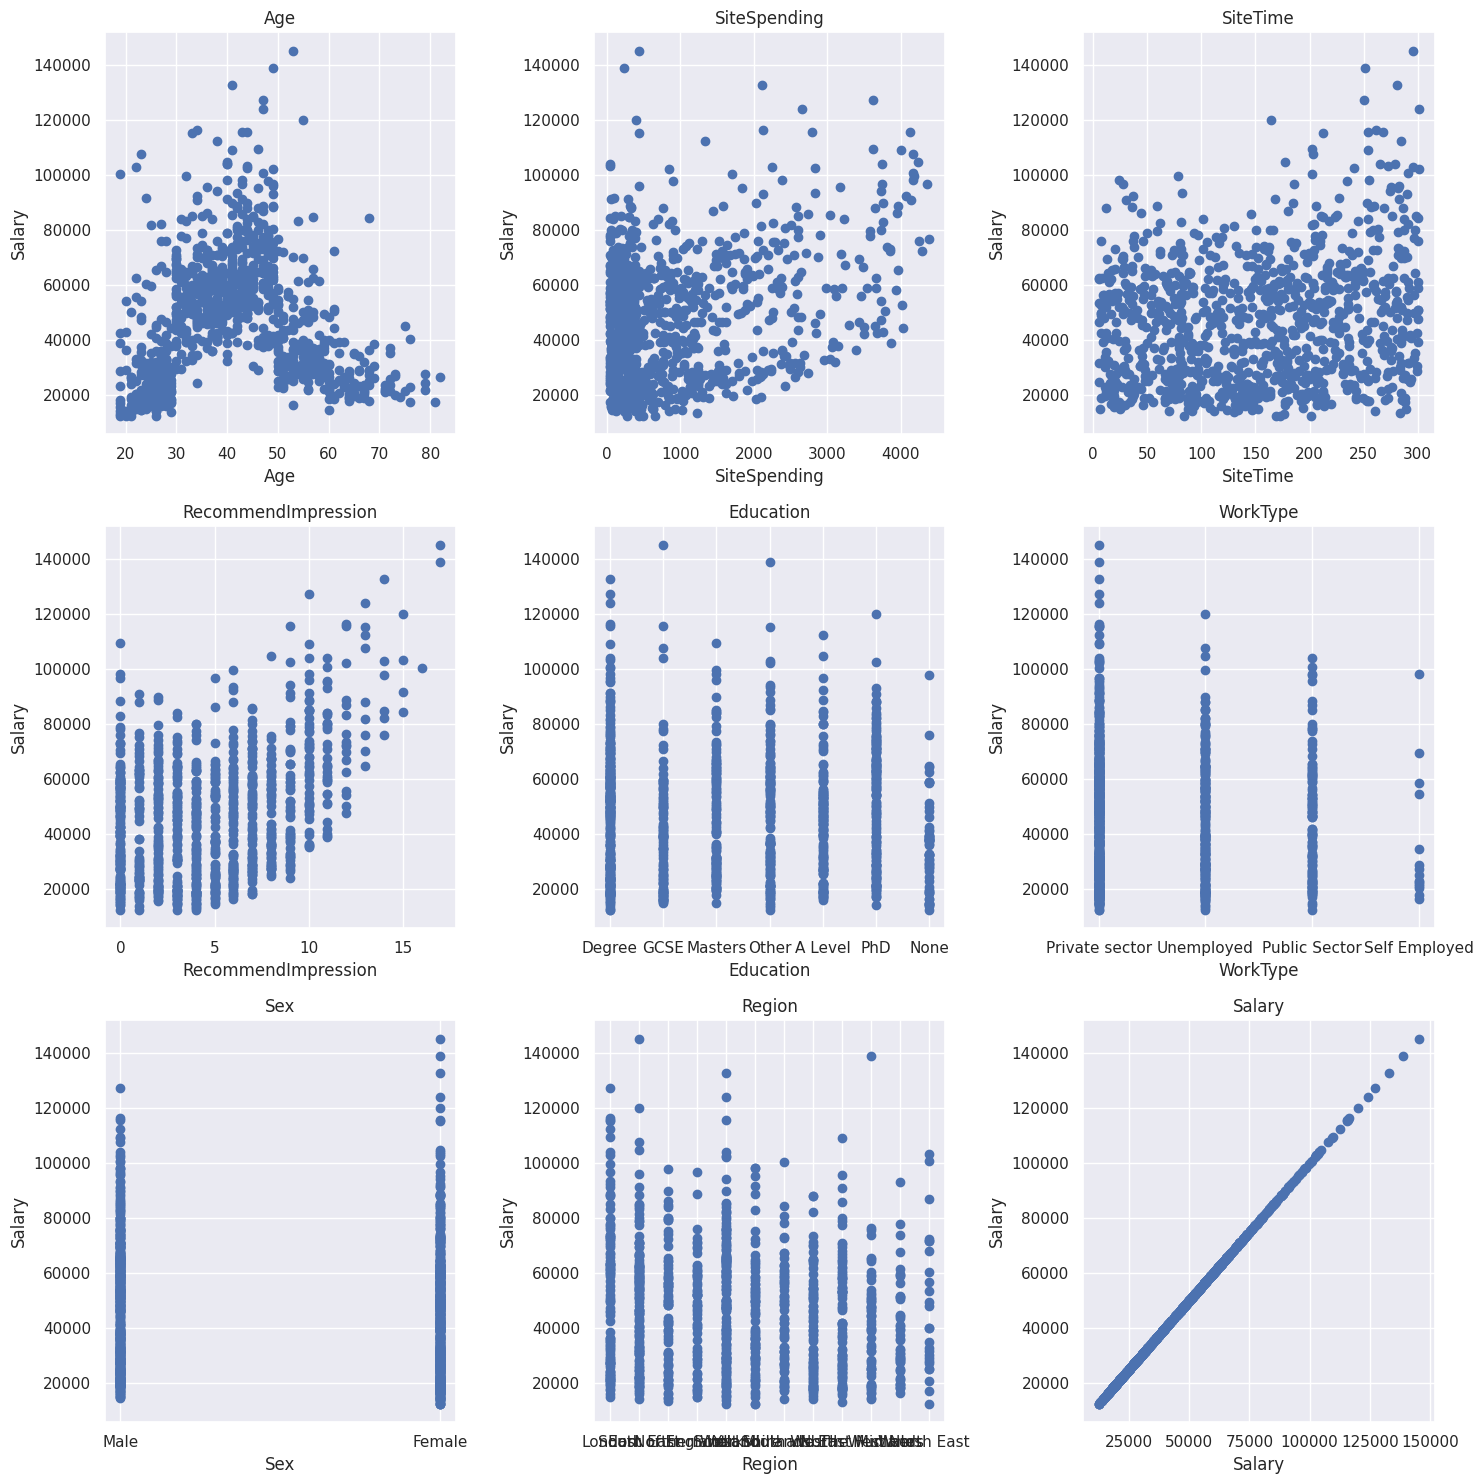

In [10]:
# @title
columns = df.columns[:]  # Assuming the first column is 'Salary' or some other column you want to exclude
n = len(columns)

# Set up a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the 3x3 grid into a list so we can iterate over it
axs = axs.ravel()

# Now plot each column against 'Salary' because this is our target column
for i in range(n):
    axs[i].scatter(df[columns[i]], df['Salary'])
    axs[i].set_title(columns[i])
    axs[i].set_ylabel('Salary')
    axs[i].set_xlabel(columns[i])


plt.tight_layout()
plt.show()


<ipython-input-8-edf63abf34c5>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', cbar=True, square=True, fmt=".2f")


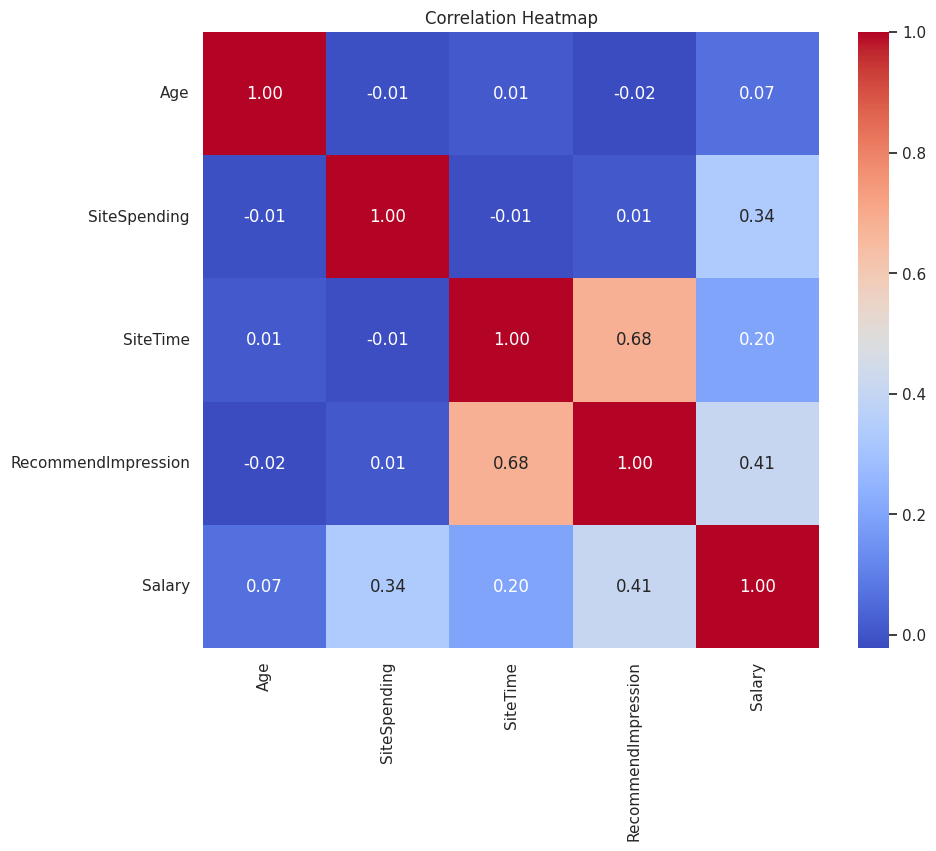

In [8]:
# @title
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', cbar=True, square=True, fmt=".2f")

plt.title("Correlation Heatmap")
plt.show()


### Performing feature selection

In [11]:
# @title
#Shuffle the dataset
rng = np.random.default_rng(0) # This sets the random seed, meaning that we will get the SAME random sample if we rerun this cell.
df = df.iloc[rng.permutation(len(df))].reset_index(drop=True) # Shuffle data


In [14]:
# @title
# Encoding the categorical Features of our dataset
lblEncoder_X = LabelEncoder()
df['Education'] = lblEncoder_X.fit_transform(df['Education'])
df['WorkType'] = lblEncoder_X.fit_transform(df['WorkType'])
df['Sex'] = lblEncoder_X.fit_transform(df['Sex'])
df['Region'] = lblEncoder_X.fit_transform(df['Region'])

#df = pd.get_dummies(df, drop_first=True)

In [13]:
# @title
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = df[['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression', 'Education',
       'WorkType', 'Sex', 'Region', 'Salary']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns
vif

,VIF,Features
0,6.658374,Age
1,2.113952,SiteSpending
2,7.364734,SiteTime
3,6.055080,RecommendImpression
4,2.540188,Education
5,1.460958,WorkType
6,1.834322,Sex
7,3.426002,Region
8,7.079411,Salary


From the above, we can see there exist no multicolinearity in our data. However, in our scatter plot, site time does not seem to have any obvious correlation with Salary and the VIF is very high. So we can proceed to either drop it or use it and see how much it contributes to our model.

In [15]:
# @title
# I assume education is ordinal, so lets order this feature and map it to our dataset:
#enc_dict = {'None': 0, 'Other':1,'GCSE':2, 'A Level':3, 'Degree':4, 'Masters':5,'PhD':6}
#df['Education'] = df['Education'].map(enc_dict):
# This wasn't the case, model performed badly.

# Select Columns
#cols = df[[ 'Age', 'SiteSpending', 'RecommendImpression', 'Education', 'Sex']]
cols = df[['Age', 'SiteSpending', 'RecommendImpression', 'Education',
       'WorkType', 'Sex', 'Region']]

*Declare the dependent and independent Variable*

In [16]:
# @title
# Select your features and Target variables
X = np.array(df[cols.columns])
y = np.array(df['Salary'])

# Split Dataset
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split your data on a 80-20 split for training and testing
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25, random_state=42)

# Poly Transform
degree = 2 # Define the maximum power of polynomial features you want to include
poly = PolynomialFeatures(degree) # Create the polynomial features object
X_train_poly = poly.fit_transform(X_train) # Fit the poly object to the training data to make a new feature matrix
X_test_poly = poly.fit_transform(X_test)
X_val_poly = poly.fit_transform(X_val)

# Standardize your Data
scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_stded = scaler.transform(X_train_poly)
X_test_poly_stded = scaler.transform(X_test_poly)
X_val_poly_stded = scaler.transform(X_val_poly)



# **PART 1: REGRESSION**

Linear regression is a type of supervised learning, where we find a linear approximation of a causal relationship between some variables and a target. It describes how a variable affects the target and is used to make predictions on estimated values. In our case study, we use it to predict the income of customers given features like age, sex, site time, etc.

We say y is a function of X given as $y=f(x_1,x_2,x_3,…,x_n )$.

$y ̂  = Xθ$

$y ̂$ to represent sample data, and y for population data.
$y ̂$ = target = dependent variable for which we are trying to predict accurately.
X = features = independent variables which we believe explain y
θ = quantifies the amount of a given X that describes $y ̂$

**Declare your target and feature variables.**

$y ̂  = Salary$

$X=[Age,Sex,SiteTime,…,Region]$

1. Polynomial features. This is because we are dealing with a multi-regression where the power of a variable $(θ_2^2)$ or its interaction between other variables $(θ_2 θ_3)$ may describe the target more accurately than a linear combination of that variable.

2. Standardize your data. This is to solve the problem of varying magnitudes in the features where in the age column, for example, our data goes from 19 to around 84.
$x_s  =  (x - μ_x)/σ_x $

3. Split the data into training and testing to avoid the problem of overfitting where our model learns accurately on the training dataset but fails when presented with new data.
4. Create the regression, train your model with the training data, and make prediction on the test data.
5. Keep optimizing and evaluating the model by experimenting with various features to reduce the cost function:

The selected cost function used is the Mean Squared Error.
$J(θ)  =  1/m 〖(Xθ - y)〗^2 (Xθ - y)$
The $R2$ is the accuracy of our model and measures the goodness of fit of a model and is mostly used as the basis for comparing models. Given as:
$R^2=  SSR/SST$
Where SSR = Variability explained by the regression
SST = total variability of the dataset.
If$〖 R〗^2 = 0$, our regression explains nothing, and if $R^2 = 1$, our regression models our data perfectly.



### SKLEARN LINEAR REGRESSION

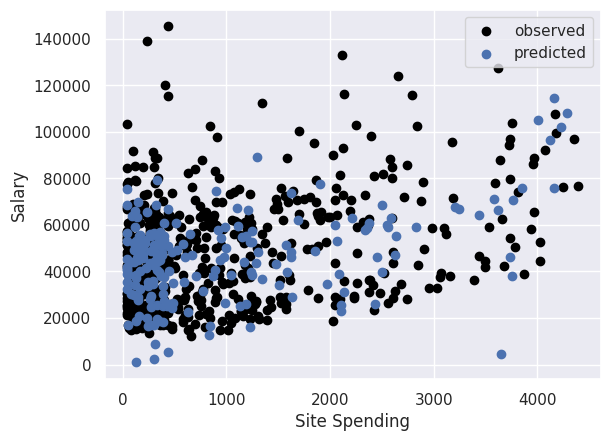

Training Score:  0.732
Validation Score:  0.629
R2 Score:  0.66
MSE:  163153530.831
MAE:  10322.927
Max error:  43033.349


In [17]:
# @title
# Create, Train the model and predict on validation and Test Data
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# one hot encoding all the categorical features and taking site time out
# we got a training score of 83% and a negative testing score.
# excluding the region, we get 74% training and 65% testing.

### KERNEL RIDGE LAPLACIAN

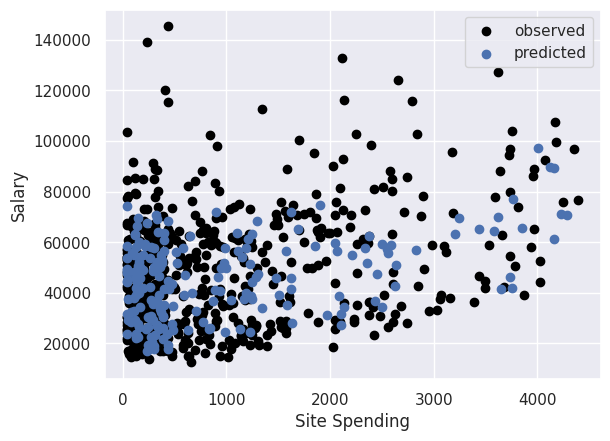

Training Score:  0.854
Validation Score:  0.786
R2 Score:  0.782
MSE:  104653082.3
MAE:  7881.056
Max error:  39440.493


In [18]:
# @title
obj = kernel_ridge.KernelRidge(kernel='laplacian')
# 79% with Site time,  83% without site time however it doesnt explain the outliers.
obj.fit(X_train_poly_stded, y_train)
y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# one hot encoding score is: 72% on training and 67% on testing.
# 80% training and 74% testing

### KERNEL RIDGE RBF

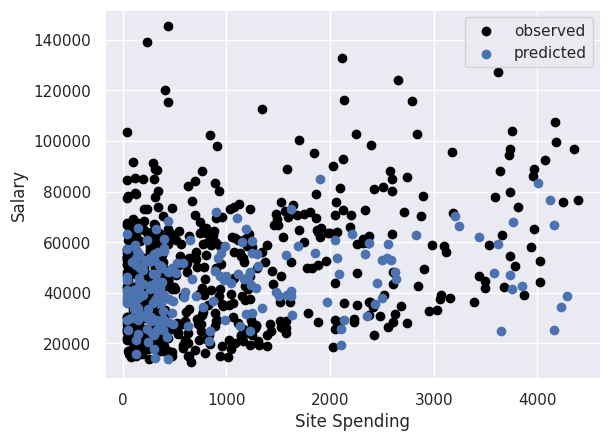

Training Score:  0.698
Validation Score:  0.548
R2 Score:  0.443
MSE:  267184812.192
MAE:  12354.677
Max error:  72572.244


In [19]:
# @title
obj = kernel_ridge.KernelRidge(kernel='rbf')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# Obs: 56% with site time, 64% without site time.
# ohe: 54% training and 7% testing.

### POLYNOMIAL

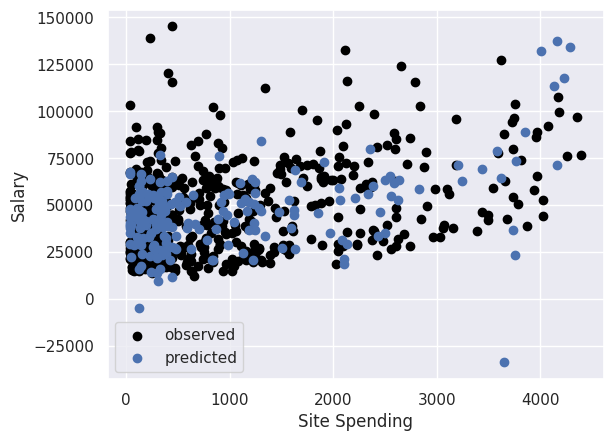

Training Score:  0.817
Validation Score:  0.61
R2 Score:  0.549
MSE:  215988056.506
MAE:  10982.152
Max error:  78791.434
Adjusted R2 on training : 0.8155574828635841
Adjusted R2 on testing : 0.5462715427196533


In [20]:
# @title
obj = kernel_ridge.KernelRidge(kernel='polynomial')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))


# obs: 60% with site time,  67% without site time.
r2 = obj.score(X_train_poly_stded, y_train)
n = X.shape[0]
p = X.shape[1]
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2
print('Adjusted R2 on training :', adj_r2)

r2 = sklearn.metrics.r2_score(y_test, y_pred)
n = X.shape[0]
p = X.shape[1]
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2
print('Adjusted R2 on testing :', adj_r2)

#ohe: 76% on training and 43% on testing


### SVM Linear

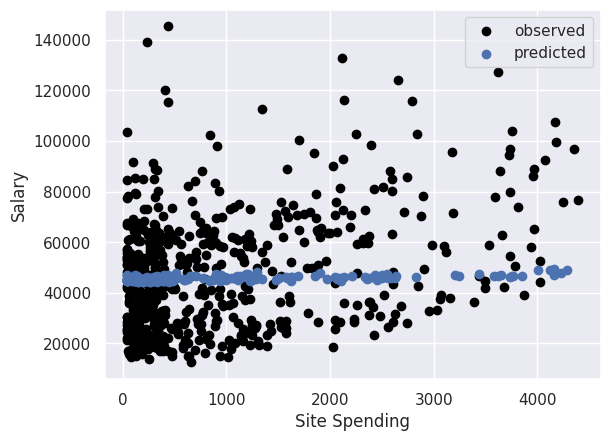

Training Score:  0.045
Validation Score:  0.041
R2 Score:  0.042
MSE:  459262865.68
MAE:  17542.113
Max error:  66744.114


In [21]:
# @title
obj = SVR(kernel='linear')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

#obs: 6% with site time, 4.8% without site time

**Adjusted R-squared **
\
 $R^2_{adj.} = 1-(1-R^2)*\frac{n-1}{n-p-1}$

### Notes:

1. Just using the numerical features with label encoded sex, and no poly fit,
    our linear model does 24% and a mean absolute error of 16186 and a max error of 58570

2. Next we assumed eductation is ordinal, encoded it mapped it to our data. This reduced
    our mean absolute error to 15828, max error to 56378 and an R2 score of 27% which is
    much better than 24%.

3. I used label encoding on the education data and this made our model perform badly.
    with an R2 score of 22.9%, MAE of 16,480 and max error of 58,662.

Based on this observation, I manually map numbers to the education data with PHD=6, and None=0.
4. I label encoded the Worktype feature, but this did not improve the model significantly,
    as we get 27% R2 score and 55638 max error. However, one hot encoding the Worktype
    further reduces the max error to 54611. Less error same R2 is a better model to me.

Since we're begining to one hot encode our data, we'll need to implement the polyfit.
5. Our model does significantly well with an R2 score of 65%, a max error of 49966 and
    mean absolute error of 9890 which is much better than all the other tests we've run.
    
6. I'm not convinced region contributes to our model, but i'm going to one hot encode it
    and add it to our feature to see how our model performs. Well, as expected, I got a
    negative R2 score -2.05, a max error of 9.92e+16. However, label encoding the region
    improves the model R2 score to 66.7%, we get a max error of 49851 and an MAE of 9793.

Increased the polynomial degree from 2 to 3 up to 10. The higher we went, the worse our
model performed.

We've been using SkLearn linear regression to get the tuning right. Let's see if regressions
will model our data correctly.

7. Lastly i'll like to just naively label encode all the categorical features and train the model with this.

Doing this our model is currently doing pretty alright with as high as 83% in laplacian, however, it does not explain the outliers in the age feature for example.
'''

# **PART 2: BINARY CLASSIFICATION**

In the real world, decision-making comes down to yes or no situations. If a customer will buy a product or not. Binary classification is a type of classification task in which there are only two possible classes that the data can belong. These two classes are typically represented as 1 and 0, with 1 representing the positive class and 0 representing the negative class.
In this section, we apply a binary classification technique to our dataset to determine if a customer's income is above 35,000 or under 35,000 as opposed to predicting an estimated value of a customer's income. The goal is to correctly classify data points into one of the two classes by training a classification model on a dataset that includes both positive and negative examples and then using the trained model to make predictions on new data.

$(h_θ (x))$ =  $((above 35k) if g_θ (x) > 0)$ / $((below 35k) if g_θ (x) < 0)$

1.	First, we represent the income of those above 35000 as 1 and those below 35000 as 0. I observed that the income of customers above 35000 is almost twice the size of those below 35000. This means the algorithm could label all new data as above 35000 and would be correct to a large degree.
2.	To avoid this bias, I under sample my dataset by reducing the number of data points above 35000 to equal those below 35000.
3.	I declared my target as the income in 0 and 1 and the rest as features.
4.	To avoid overfitting, I split my data into training and testing sets without the validation as our data points are now very small and might not be enough to train the model with.
5.	I standardize the features like in regression to solve the difference in magnitude problem by subtracting the mean from each data point and dividing by the standard deviation.
6.	Next, I fit my classification algorithm. We would be looking at the Logistic Regression, Support Vector, and Decision tree algorithm
7.	We evaluate our models and compare them for the best-performing model using its confusion matrix and accuracy.


In [22]:
# @title
# We classify our Target into two categories, those with salary above 35000 or not.

df['target'] = df['Salary'].apply(lambda x: 1 if x > 35000 else 0)

#Shuffle the data again
# Shuffle the dataset again
rng = np.random.default_rng(0)
df = df.iloc[rng.permutation(len(df))].reset_index(drop=True)

#Lets have a look at the numbers
df.target.value_counts() # we see there are more salary above $35000


1    631
0    369
Name: target, dtype: int64

In [23]:
# @title
# Even though our model gave usa high accuracy using, i think it'll be bias towards the
# salary above 35k cos it's almost 2ce the size of the salary under 35k
# Next lets resample our target and rerun our model.
df_over = df[(df['target']==1)]
df_under = df[(df['target']==0)]

df_undersampled = resample(df_over, replace=True,n_samples= len(df_under),random_state=42)
df_undersampled = pd.concat([df_undersampled, df_under])

df_undersampled['target'].value_counts()

1    369
0    369
Name: target, dtype: int64

In [24]:
# @title
df_undersampled.drop(['Salary'], axis=1)
# Declare your target and feature columns
cols = df_undersampled[[ 'Age', 'SiteSpending','RecommendImpression']]

X = np.array(df_undersampled[cols.columns])
y = np.array(df_undersampled['target'])

In [25]:
# @title
# Split your data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [26]:
# @title
#Standardize your dataset
scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes

X_train = scaler.transform(X_train) # standardize X_train
X_test = scaler.transform(X_test)

###  Logistic Regression

In [33]:
# Create logistic regression object

obj = sklearn.linear_model.LogisticRegression(penalty='l1', C=10, solver='liblinear',random_state=40)

# Tuning hyperparamters: obj = sklearn.linear_model.LogisticRegression(penalty='l1', C=0.01, solver='liblinear',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)


The training score: 0.664
Accuracy: 0.6554
Confusion matrix:  [[50 19]
 [32 47]]
              precision    recall  f1-score   support

           0       0.61      0.72      0.66        69
           1       0.71      0.59      0.65        79

    accuracy                           0.66       148
   macro avg       0.66      0.66      0.66       148
weighted avg       0.66      0.66      0.65       148



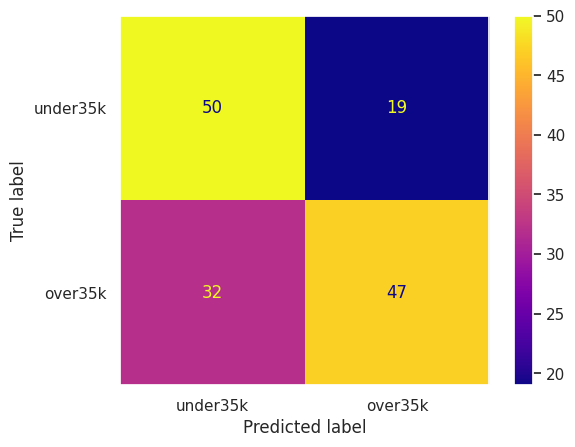

In [34]:
# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

In [35]:
# Checking p-values and removing p-values that are close to 1 as they do not contribute to our model
x1 = sm.add_constant(X_train)
reg_log = sm.Logit(y_train, x1)
results_log = reg_log.fit()
results_log.pred_table()

Optimization terminated successfully.
         Current function value: 0.613605
         Iterations 5


array([[207.,  93.],
       [104., 186.]])

In [36]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  590
Model:                          Logit   Df Residuals:                      586
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                  0.1146
Time:                        15:03:04   Log-Likelihood:                -362.03
converged:                       True   LL-Null:                       -408.87
Covariance Type:            nonrobust   LLR p-value:                 3.529e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.089     -0.246      0.806      -0.197       0.153
x1             0.1537      0.089      1.724      0.085      -0.021       0.328
x2             0.4913      0.096      5.115      0.000       0.303       0.680
x3             0.7497      0.097      7.719      0.000       0.559       0.940
==============================================================================
"""

###  SVM

The training score: 0.953
Accuracy: 0.9459
Confusion matrix:  [[63  6]
 [ 2 77]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.93      0.97      0.95        79

    accuracy                           0.95       148
   macro avg       0.95      0.94      0.95       148
weighted avg       0.95      0.95      0.95       148



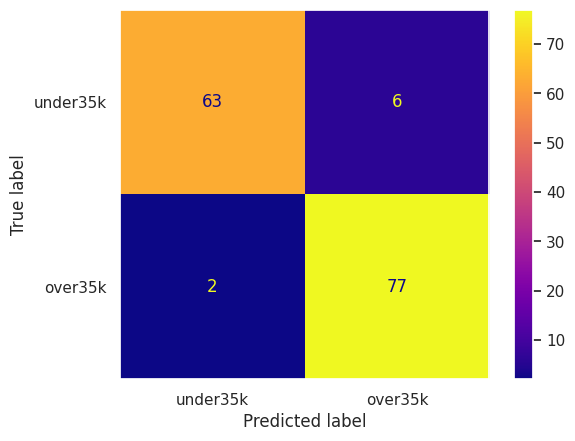

In [37]:
# @title
# Tuning hyperparamters: penalty='l1', C=10, solver='liblinear'
import sklearn.svm

# Create support vector classifier object
obj = sklearn.svm.SVC(C=10,kernel='rbf',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

# The higher the better# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

###  Decision Tree

The training score: 0.964
Accuracy: 0.9459
Confusion matrix:  [[63  6]
 [ 2 77]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.93      0.97      0.95        79

    accuracy                           0.95       148
   macro avg       0.95      0.94      0.95       148
weighted avg       0.95      0.95      0.95       148



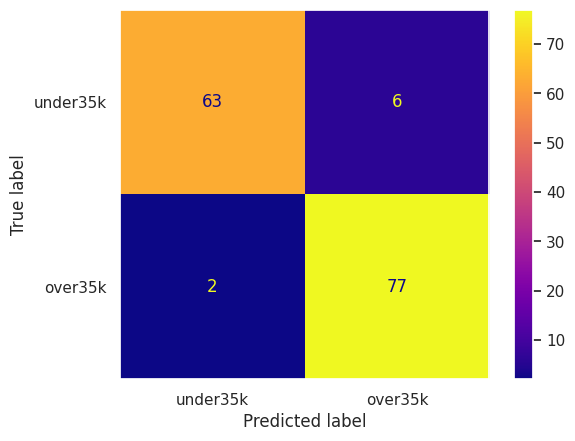

In [39]:
# @title
# Create Decison Tree object
from sklearn.tree import DecisionTreeClassifier
obj = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=9,random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_new_pred = obj.predict(X_test)

# The higher the better
# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

# **PART 3: NEURAL NETWORK**

A neural network is a type of machine learning that tries to model the working of the brain and its neurons. In the classification task performed above, the classification algorithms used are good at modeling linear relationships and binary classification tasks however, they are not very good at modeling complex, nonlinear relationships. Neural networks can learn and improve automatically and can model high-dimensional data better than the other classification algorithms we have used. It takes input data, processes it through its nodes called neurons using the weights and biases of the features, and gives us an output.
Given by the equation:

$a^(〖out〗^T )= 〖f(b^T+a〗^(〖in〗^T ) w)$

Where $a^(〖in〗^T )$ = the input row vector of the layer

$a^(〖out〗^T )$= the output row vector of the layer

w = the kernel parameter of the layer

$b^T=$ the bias parameter of the layer

f = the activation function of the model.


1.	Take input data.
2.	Fit the algorithm to model the data. In this case, classification.
3.	Apply an objective function, which is a measure used to evaluate how well the models' output matches our desired output. Like in other algorithms where we try to minimize our loss function.
4.	Apply an optimization algorithm by varying the models' parameters until we get the smallest loss function.


In [47]:
df_undersampled.drop(['Salary'], axis=1)
# Declare your target and feature columns
cols = df_undersampled[[ 'Age', 'SiteSpending','RecommendImpression']]

X_nn = np.array(df_undersampled[cols.columns])
y_nn = np.array(df_undersampled['target'])

In [48]:
#Split your data
X_nn_, X_nn_test, y_nn_, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(X_nn_, y_nn_, test_size=0.25, random_state=42)

In [49]:
# Standardize your data
scaler = StandardScaler()
scaler.fit(X_nn_train) # calculate the mean and variance for each feature and store to attributes

X_nn_train = scaler.transform(X_nn_train) # standardize X_train
X_nn_test = scaler.transform(X_nn_test)
X_nn_val = scaler.transform(X_nn_val)

### Random tests

In [63]:
import tensorflow as tf
input_size = 8
output_size = 2
hidden_layer_size = 50

acc = BinaryAccuracy()

model = tf.keras.Sequential([tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(output_size, activation='softmax'),
                             ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 100
max_epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit(X_nn_train,y_nn_train,
          batch_size = batch_size, epochs = max_epochs, validation_data= (X_nn_val, y_nn_val),
          callbacks = [early_stopping],
          verbose = 2)

Epoch 1/100
5/5 - 1s - loss: 0.6657 - accuracy: 0.6041 - val_loss: 0.6319 - val_accuracy: 0.6757 - 1s/epoch - 268ms/step
Epoch 2/100
5/5 - 0s - loss: 0.6378 - accuracy: 0.6719 - val_loss: 0.6030 - val_accuracy: 0.6959 - 41ms/epoch - 8ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6133 - accuracy: 0.7036 - val_loss: 0.5801 - val_accuracy: 0.7230 - 58ms/epoch - 12ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5930 - accuracy: 0.7081 - val_loss: 0.5584 - val_accuracy: 0.7432 - 41ms/epoch - 8ms/step
Epoch 5/100
5/5 - 0s - loss: 0.5735 - accuracy: 0.7308 - val_loss: 0.5367 - val_accuracy: 0.7500 - 55ms/epoch - 11ms/step
Epoch 6/100
5/5 - 0s - loss: 0.5556 - accuracy: 0.7376 - val_loss: 0.5150 - val_accuracy: 0.7635 - 41ms/epoch - 8ms/step
Epoch 7/100
5/5 - 0s - loss: 0.5376 - accuracy: 0.7398 - val_loss: 0.4953 - val_accuracy: 0.7635 - 56ms/epoch - 11ms/step
Epoch 8/100
5/5 - 0s - loss: 0.5216 - accuracy: 0.7443 - val_loss: 0.4783 - val_accuracy: 0.7635 - 57ms/epoch - 11ms/step
Epoch 9/100
5/5 - 0s - loss:

In [64]:
test_loss, test_accuracy = model.evaluate(X_nn_test, y_nn_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.2297 - accuracy: 0.9189


In [65]:
history = model.fit(X_nn_train,y_nn_train,
          batch_size = batch_size, epochs = max_epochs, validation_data= (X_nn_val, y_nn_val),
          callbacks = [early_stopping],
          verbose = 2)


Epoch 1/100
5/5 - 0s - loss: 0.2486 - accuracy: 0.9005 - val_loss: 0.2390 - val_accuracy: 0.8986 - 122ms/epoch - 24ms/step
Epoch 2/100
5/5 - 0s - loss: 0.2462 - accuracy: 0.9005 - val_loss: 0.2346 - val_accuracy: 0.8919 - 79ms/epoch - 16ms/step
Epoch 3/100
5/5 - 0s - loss: 0.2429 - accuracy: 0.9005 - val_loss: 0.2347 - val_accuracy: 0.9054 - 73ms/epoch - 15ms/step
Epoch 4/100
5/5 - 0s - loss: 0.2410 - accuracy: 0.9050 - val_loss: 0.2353 - val_accuracy: 0.9054 - 70ms/epoch - 14ms/step


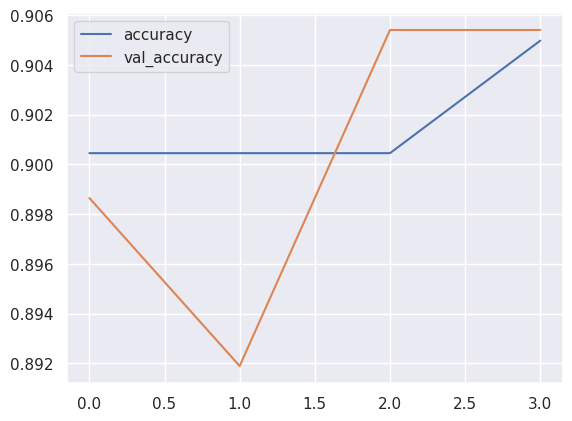

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [67]:
Y_test_logit = model.predict(X_nn_test)


5/5 [==============================] - 0s 3ms/step


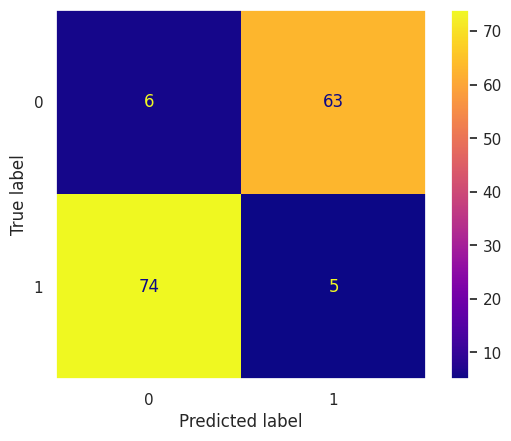

In [68]:
Y_test_pred = (Y_test_logit > 0.5).astype(int)
# Evaluate the model by plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_nn_test, Y_test_pred[:,0]))
disp.plot(cmap=plt.cm.plasma)
plt.grid(False)

### Main NN Model

In [56]:
# @title
# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# The as we are performing binary classification, we specify `activation=sigmoid`.
# We apply l2 regularization on the kernel parameters by specifying a `kernel_regularizer` argument.
dense_layer_1 = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)
output_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_nn_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output])

# Output the summary of the model.
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_3 (Dense)             (None, 10)                40        
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [57]:
# @title
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and the binary cross entropy function (a `BinaryCrossentropy` instance)
# as a loss function.

# If we want to observe metrics other than the loss function we specified,
# we can also specify the metrics in the `metrics` parameter
# in the `compile` method.

sgd = SGD(learning_rate=0.04)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

Epoch 1/50
5/5 [==============================] - 1s 47ms/step - loss: 0.8458 - binary_accuracy: 0.4140 - val_loss: 0.8599 - val_binary_accuracy: 0.3581
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.8276 - binary_accuracy: 0.4072 - val_loss: 0.8424 - val_binary_accuracy: 0.3649
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.8120 - binary_accuracy: 0.4140 - val_loss: 0.8270 - val_binary_accuracy: 0.3581
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.7984 - binary_accuracy: 0.4118 - val_loss: 0.8134 - val_binary_accuracy: 0.3581
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7865 - binary_accuracy: 0.4118 - val_loss: 0.8014 - val_binary_accuracy: 0.3649
Epoch 6/50
5/5 [==============================] - 0s 14ms/step - loss: 0.7763 - binary_accuracy: 0.4231 - val_loss: 0.7906 - val_binary_accuracy: 0.3784
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7669 - bi

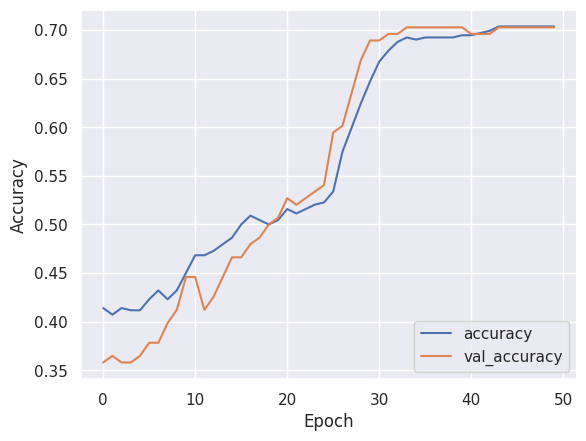

In [58]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

history = model.fit(X_nn_train, y_nn_train, batch_size=90, epochs=50, validation_data=(X_nn_val, y_nn_val))


# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [59]:
ce_test, acc_test = model.evaluate(X_nn_test, y_nn_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.6148 - binary_accuracy: 0.7095
The cross entropy loss on the test data: 0.6148011684417725
The accuracy on the test data: 0.7094594836235046


In [60]:
Y_test_logit = model.predict(X_nn_test)
print(Y_test_logit[:10]) # just show you the first 10 to not spam you

5/5 [==============================] - 0s 2ms/step
[[0.7698573 ]
 [0.541321  ]
 [0.6283719 ]
 [0.2748902 ]
 [0.681279  ]
 [0.49241745]
 [0.42816374]
 [0.4310184 ]
 [0.33040652]
 [0.43395326]]


In [61]:
Y_test_pred = (Y_test_logit > 0.5).astype(int)
print(Y_test_pred[:10])

[[1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


The accuracy on the test data with the selected hyperparameter: 0.7094594594594594
The F1 score on the test data with the selected hyperparameter: 0.6950354609929077
Precision on validation data: 0.7903225806451613
Recall on validation data: 0.7903225806451613


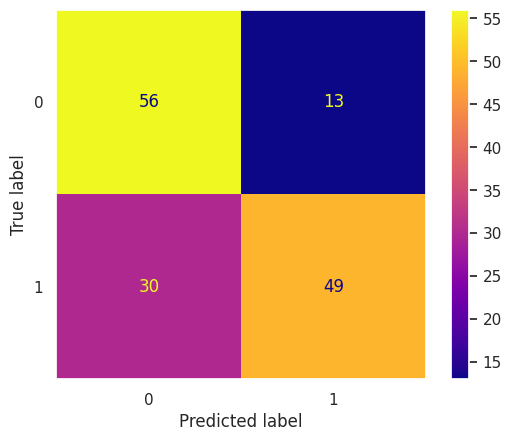

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_nn_test, Y_test_pred))
disp.plot(cmap=plt.cm.plasma)
plt.grid(False)

acc_test = accuracy_score(y_nn_test, Y_test_pred)
f1_test = f1_score(y_nn_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_nn_test, Y_test_pred, pos_label=1)
print('Precision on validation data:', pre_test)
reca_test = precision_score(y_nn_test, Y_test_pred, pos_label=1)
print('Recall on validation data:', reca_test)

# **PART 3: CLUSTERING**

In [40]:
X = df.copy()

## K-Means Clustering

Clustering is an unsupervised learning where we group data points based on their similarities and dissimilarities. Unlike in classification where we know the data points and are trying to train the machine to be able to predict accurately, in clustering we do not know what the labels are and try to identify the underlying patterns in the data.
In this data sample, we apply the k-means clustering algorithm to our data by dividing our data into clusters and where each cluster is represented by a centroid. The centroid is the mean of all the points in the cluster given by the equation

$√({∑_{i=1}^n(x_i- y_i )^2 } )$

$x_i=datapoint,y_i=centroid and n=number of features$.

1.	We assign the random value of k.
2.	Then we select an initial cluster of centroids
3.	Calculate the distance between each object to each cluster centroid.
4.	Assign each object to the centroid closest to it.
5.	Compute the new centroid for each cluster until there is no change in the clusters.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

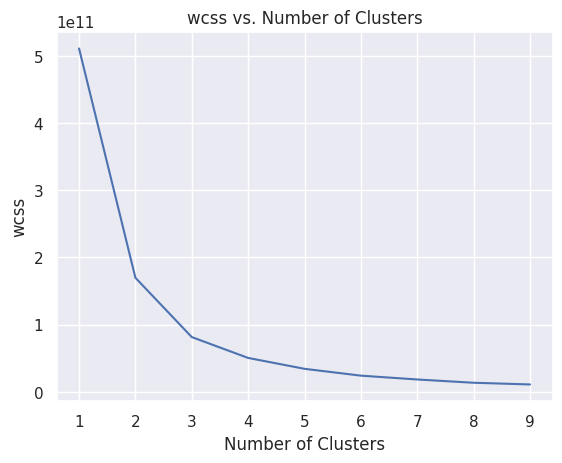

In [41]:
# @title
# Trying to find the best number of clusters
# Initialize a list to store the inertia values
wcss = []

# Loop over a range of number of clusters
for i in range(1, 10):
  # Initialize the model with the current number of clusters
  model = KMeans(n_clusters=i, random_state=0)

  # Fit the model to the data
  model.fit(X)

  # Get the inertia for the model
  inertia = model.inertia_

  # Append the inertia to the list
  wcss.append(inertia)

# Plot the inertia values
plt.plot(range(1, 10), wcss)

# Add a title and labels to the plot
plt.title('wcss vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')

# Show the plot
plt.show()

In [42]:
# @title
# Initialize the model with gotten k
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the data
model.fit(X)

# Predict the clusters for each data point
predictions = model.predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


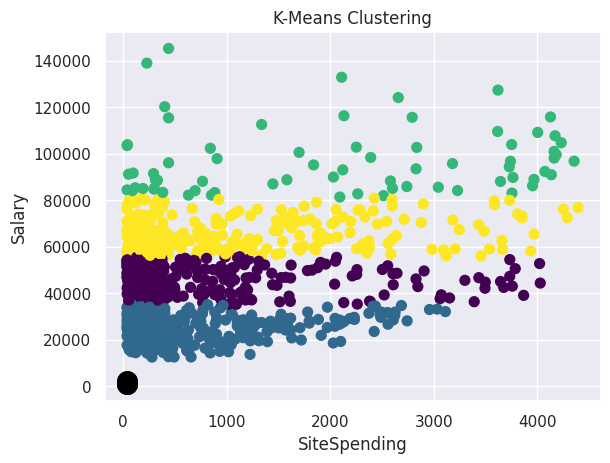

In [43]:
# @title
# Select the columns to use for the x and y axes
x_column = 'SiteSpending'
y_column = 'Salary'

# Extract the values for the x and y axes
x = df[x_column]
y = df[y_column]

# Get the cluster labels for each data point
labels = model.predict(X)

# Create a scatter plot of the data
plt.scatter(x, y, c=labels, cmap='viridis', s=50)

# Add the cluster centers to the plot
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

# Add the x and y labels and a title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('K-Means Clustering')
plt.show()

In [44]:
# @title
x_scaled = preprocessing.scale(X)
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the data
model.fit(x_scaled)

# Predict the clusters for each data point
predictions = model.predict(x_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


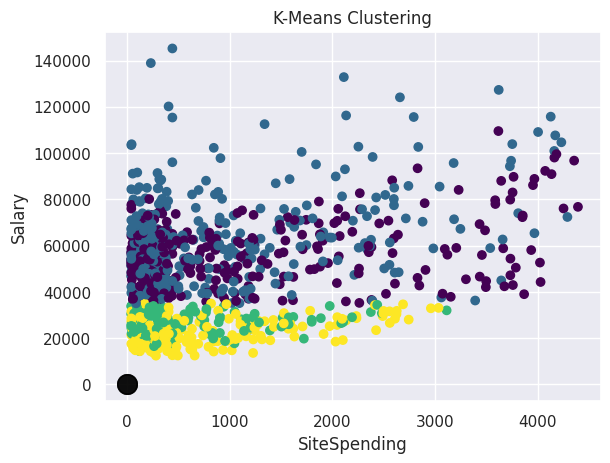

In [45]:
# @title
# Select the columns to use for the x and y axes
x_column = 'SiteSpending'
y_column = 'Salary'

# Extract the values for the x and y axes
x = df[x_column]
y = df[y_column]

# Get the cluster labels for each data point
labels = model.predict(x_scaled)

# Create a scatter plot of the data
plt.scatter(x, y, c=labels, cmap='viridis')

# Add the cluster centers to the plot
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Add the x and y labels and a title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('K-Means Clustering')

# Show the plot
plt.show()

In [46]:
from sklearn.metrics import silhouette_score
print(silhouette_score(x_scaled, labels))

0.17117942704579303


# Conclusion

This report discusses the use of machine learning techniques to classify and predict the income of customers for a fictional eCommerce company. The focus of the report is on regression, a type of supervised learning, and how it can be used to predict income based on features such as age, website usage, and sector of employment. We compare serveral regression algorithms with Kernel ridge laplacian providing the best accuracy with about 78%. We split our dataset into users that ean above 35k and those that earn less and try both traditional classification algorithms and Neural network. We observe decision tree algorithm with 94% accuracy performs the best of the traditional algorithms and also outperforms our neural network. This shows that while neural network is great, some small tasks like in our case is better carried out with traditional algorithms.